# Imports

In [2]:
import os
import time
import tqdm
import torch
import random
import torch
import IPython
import torchvision
import requests, urllib

import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
from torchvision.models import AlexNet
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

from PIL import Image
from io import BytesIO

# Helper functions

In [3]:
def set_seed(seed=None, seed_torch=True):
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

    print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
def set_device():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    return device

SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.


# Modern CNNs and Transfer Learning

In [4]:
class FullyConnectedNet(nn.Module):
    def __init__(self):
        super(FullyConnectedNet, self).__init__()

        image_width = 128
        image_channels = 3
        self.input_size = image_channels * image_width ** 2

        self.fc1 = nn.Linear(self.input_size, 256)

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.fc1(x)

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3,
                                out_channels=256,
                                kernel_size=(3, 3),
                                padding=1)

    def forward(self, x):
        return self.conv1(x)

In [6]:
def get_parameter_count(network):
    """
    Calculate the number of parameters used by the fully connected network.
    Hint: Casting the result of network.parameters() to a list may make it
        easier to work with

    Args:
      network: Network to calculate the parameters of

    Returns:
      param_count: The number of parameters in the network
    """

    # Get the network's parameters
    parameters = list(network.parameters())

    param_count = 0
    # Loop over all layers
    for layer in parameters:
        param_count += torch.numel(layer)

    return param_count

# Initialize networks
fccnet = FullyConnectedNet()
convnet = ConvNet()
print(f"FCCN parameter count: {get_parameter_count(fccnet)}")
print(f"ConvNet parameter count: {get_parameter_count(convnet)}")

FCCN parameter count: 12583168
ConvNet parameter count: 7168


# Big and Deep ConvNets

## AlexNet

In [7]:
# original link: https://s3.amazonaws.com/pytorch/models/alexnet-owt-4df8aa71.pth
state_dict = torch.hub.load_state_dict_from_url("https://osf.io/9dzeu/download")

alexnet = AlexNet()
alexnet.load_state_dict(state_dict=state_dict)

url, filename = ("https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D2_ModernConvnets/static/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

input_image = Image.open(filename)
preprocess = transforms.Compose([
                                 transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225]),
                                 ])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)  # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.cuda()
    alexnet.cuda()

Downloading: "https://osf.io/9dzeu/download" to /Users/zachary.sheldon/.cache/torch/hub/checkpoints/download


  0%|          | 0.00/233M [00:00<?, ?B/s]

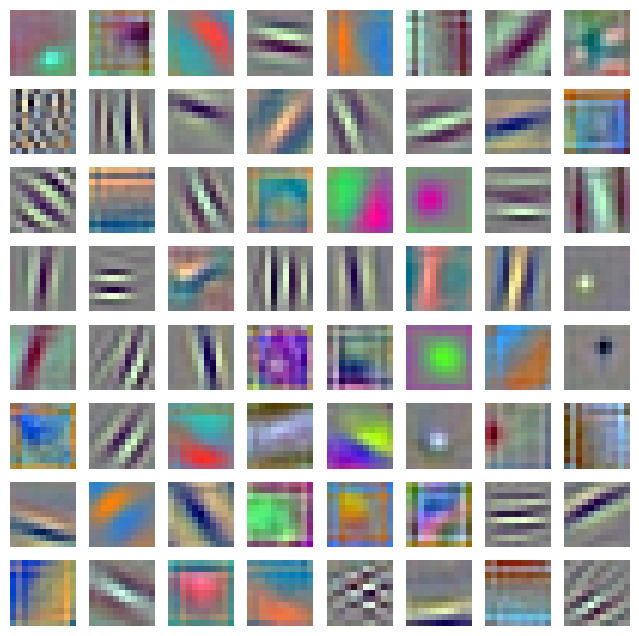

In [8]:
with torch.no_grad():
    params = list(alexnet.parameters())
    fig, axs = plt.subplots(8, 8, figsize=(8, 8))
    filters = []
    for filter_index in range(params[0].shape[0]):
        row_index = filter_index // 8
        col_index = filter_index % 8

        filter = params[0][filter_index,:,:,:]
        filter_image = filter.permute(1, 2, 0).cpu()
        scale = np.abs(filter_image).max()
        scaled_image = filter_image / (2 * scale) + 0.5
        filters.append(scaled_image.cpu())
        axs[row_index, col_index].imshow(scaled_image.cpu())
        axs[row_index, col_index].axis('off')
    plt.show()

## Depthwise separable convolutions

Another way to reduce the computational cost of large models is the use of depthwise separable convolutions ([introduced here](https://www.di.ens.fr/data/publications/papers/phd_sifre.pdf)). Depthwise separable convolutions are the key component making [MobileNets](https://arxiv.org/abs/1704.04861) efficient.

<img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D2_ModernConvnets/static/SchematicCNN.png">

# Transfer Learning

It is common in computer vision to take a large model trained on a large dataset (often ImageNet), replace the classification layer and fine-tune the entire network to perform a different task. 

Here we'll be using a pre-trained ResNet model to classify types of Pokemon.

In [10]:
import zipfile, io

# original link: https://github.com/ben-heil/cis_522_data.git
url = 'https://osf.io/u4njm/download'

fname = 'small_pokemon_dataset'

if not os.path.exists(fname+'zip'):
    print("Data is being downloaded...")
    r = requests.get(url, stream=True)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()
    print("The download has been completed.")
else:
    print("Data has already been downloaded.")

Data is being downloaded...
The download has been completed.


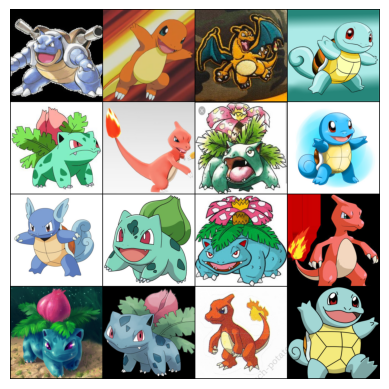

In [11]:
train_transform = transforms.Compose((transforms.Resize((256, 256)),
                                      transforms.ToTensor()))

pokemon_dataset = ImageFolder('small_pokemon_dataset',
                              transform=train_transform)

image_count = len(pokemon_dataset)
train_indices = []
test_indices = []
for i in range(image_count):
    # Put ten percent of the images in the test set
    if random.random() < .1:
        test_indices.append(i)
    else:
        train_indices.append(i)

pokemon_test_set = torch.utils.data.Subset(pokemon_dataset, test_indices)
pokemon_train_set = torch.utils.data.Subset(pokemon_dataset, train_indices)

pokemon_train_loader = torch.utils.data.DataLoader(pokemon_train_set,
                                                   batch_size=16,
                                                   shuffle=True,)
pokemon_test_loader = torch.utils.data.DataLoader(pokemon_test_set,
                                                  batch_size=16)

dataiter = iter(pokemon_train_loader)
images, labels = dataiter.next()

# show images
plt.imshow(make_grid(images, nrow=4).permute(1, 2, 0))
plt.axis('off')
plt.show()

In [13]:
num_classes = 0
for folders in os.listdir('small_pokemon_dataset/'):
    num_classes += 1
print(f"{num_classes} types of Pokemon")

9 types of Pokemon


In [14]:
resnet = torchvision.models.resnet18(pretrained=True)
num_ftrs = resnet.fc.in_features
# reset final fully connected layer, number of classes = types of Pokemon = 9
resnet.fc = nn.Linear(num_ftrs, num_classes)
resnet.to(DEVICE)
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

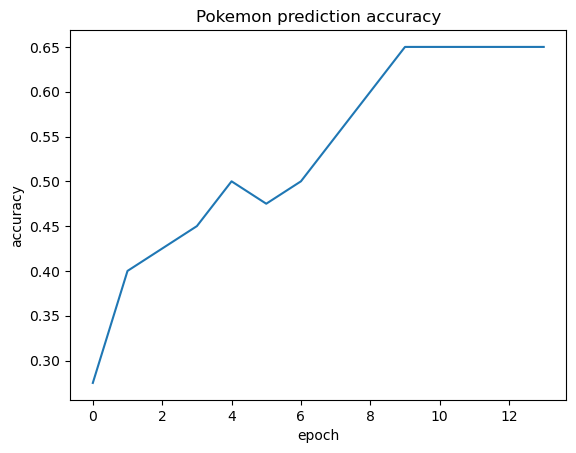

In [ ]:
pretrained_accs = []
for epoch in tqdm.tqdm(range(10)):
    # Train loop
    for batch in pokemon_train_loader:
        images, labels = batch
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        output = resnet(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

        # Eval loop
        with torch.no_grad():
            loss_sum = 0
            total_correct = 0
            total = len(pokemon_test_set)
            for batch in pokemon_test_loader:
                images, labels = batch
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)
                output = resnet(images)
                loss = loss_fn(output, labels)
                loss_sum += loss.item()

                predictions = torch.argmax(output, dim=1)

                num_correct = torch.sum(predictions == labels)
                total_correct += num_correct

            # Plot accuracy
            pretrained_accs.append(total_correct / total)
            plt.plot(pretrained_accs)
            plt.xlabel('epoch')
            plt.ylabel('accuracy')
            plt.title('Pokemon prediction accuracy')
            IPython.display.clear_output(wait=True)
            IPython.display.display(plt.gcf())
        plt.close()